In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import random

In [4]:
def mult_chance(row,mult_lst,chance):
    if np.random.random() < chance:
        return row * mult_lst
    return row

def gen_50(mult_lst):
    # gen dataframe of random values from 0.1 to 0.2
    df = pd.DataFrame(np.random.uniform(0.1,0.2,size=(50, 10)))

    # multiply some rows by a specific list at a certain chance
    df = df.apply(lambda x: mult_chance(x,mult_lst,0.2), axis=1)
    return df

,0,1,2,3,4,5,6,7,8,9
0,0.251866,0.231055,0.185355,0.219153,0.190766,0.142216,0.163567,0.169097,0.142962,0.176928
1,0.137481,0.159948,0.131435,0.162839,0.119288,0.187439,0.113183,0.117842,0.152798,0.146571
2,0.121580,0.186748,0.183153,0.135467,0.191310,0.172078,0.178153,0.122032,0.169720,0.122117
3,0.119615,0.193784,0.138262,0.106942,0.129685,0.150225,0.119323,0.127071,0.181262,0.101663
4,0.147339,0.149843,0.117734,0.136878,0.156865,0.160624,0.198033,0.133463,0.115248,0.126906


<AxesSubplot: >

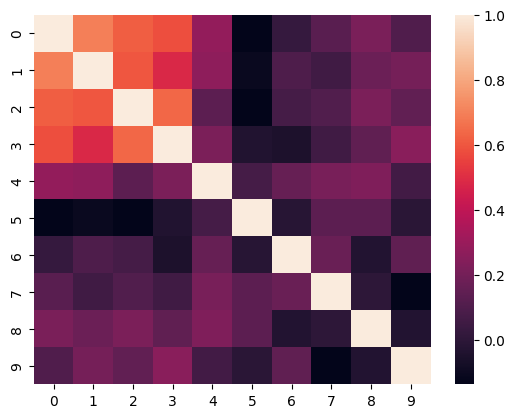

In [8]:
male_lst = [
        2,
        1.8,
        1.6,
        1.4,
        1.2,
        1,
        1,
        1,
        1,
        1
    ]

df = gen_50(male_lst)
display(df.head())
sns.heatmap(df.corr())

,0,1,2,3,4,5,6,7,8,9
0,0.104679,0.148318,0.196807,0.137549,0.159156,0.115130,0.146587,0.173856,0.146377,0.134636
1,0.147243,0.141182,0.192965,0.173636,0.142675,0.139964,0.179475,0.166856,0.171829,0.196599
2,0.170783,0.102754,0.132311,0.125596,0.100308,0.223192,0.244297,0.285612,0.197232,0.233332
3,0.196617,0.182510,0.117603,0.107484,0.141350,0.137579,0.183135,0.100285,0.159671,0.148071
4,0.140886,0.168982,0.126951,0.157346,0.104817,0.136896,0.225661,0.200373,0.268860,0.300347


<AxesSubplot: >

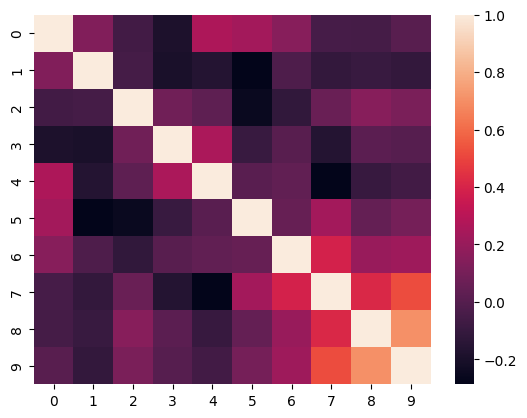

In [10]:
female_lst = [
        1,
        1,
        1,
        1,
        1,
        1.2,
        1.4,
        1.6,
        1.8,
        2
    ]

df = gen_50(female_lst)
display(df.head())
sns.heatmap(df.corr())

## List of sim correlation matrices for testing GNN

The lst below contains 100 tuples. Index 0 has 'M' or "F' and index 1 is the correlation matrix.

In [23]:
lst = []

for i in np.arange(50):
    df = gen_50(male_lst)
    lst += [('M',df.corr())]
for i in np.arange(50):
    df = gen_50(female_lst)
    lst += [('F',df.corr())]
random.shuffle(lst)

<AxesSubplot: >

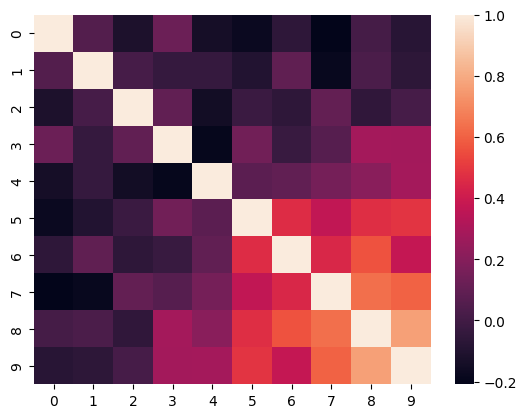

In [25]:
sns.heatmap(lst[0][1])